In [1]:
import numpy as np

data = np.load("data/data.npz") #change to data_augm to train the model on case where there is no fly in sight
images = data["images"]
# The images are stored in a 4D array (n_images, n_eyes, n_rows, n_cols)
print(f"Shape of images: {images.shape}")
# The positions of the second fly are stored in polar coordinates (r, theta)
r = data["r"]
theta = data["theta"]
data.close()

Shape of images: (10000, 2, 16, 31)


In [2]:
################################################################
# TODO: Convert the polar coordinates to cartesian coordinates
coords_lr = r * np.exp(1j * (np.pi / 4 - theta))
coords_lr = np.column_stack([coords_lr.real, coords_lr.imag])
################################################################
print(coords_lr.shape)

# The shape should be (# of samples, 2)
assert coords_lr.shape == (len(images), 2)

(10000, 2)


In [3]:
import torch
import torch.nn as nn


class DistanceLoss(nn.Module):
    def __init__(self):
        super(DistanceLoss, self).__init__()

    def forward(self, output, target):
        # Calculate the Euclidean distance between output and target
        distance = torch.sqrt(torch.sum((output - target) ** 2, dim=-1))
        return distance.mean()

# Initialize the loss function
distance_loss = DistanceLoss()


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(torch.tensor(images), torch.tensor(coords_lr))
datasets = dict(
    zip(["train", "val", "test"], random_split(dataset, [8000, 1000, 1000]))
)
batch_size = 32
loaders = {
    name: DataLoader(dataset, batch_size=batch_size, shuffle=name == "train")
    for name, dataset in datasets.items()
}

Train the whole model to detect the fly and give the position

In [5]:
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Define your layers here
        self.features = nn.Sequential(
            nn.Conv2d(2, 8, 3, groups=2),  # Convolutional layer
            nn.ReLU(inplace=True),         # ReLU activation in-place
            nn.BatchNorm2d(8),             # Batch normalization
            nn.Conv2d(8, 8, 3, groups=2),  # Second convolutional layer
            nn.ReLU(inplace=True),         # ReLU activation in-place
            nn.BatchNorm2d(8),             # Batch normalization
            nn.Conv2d(8, 8, 3, groups=2),  # Third convolutional layer
            nn.ReLU(inplace=True),         # ReLU activation in-place
            nn.MaxPool2d(2, 2)             # Max pooling layer
        )

        self.fc1 = nn.LazyLinear(16)  # Lazy linear layer
        self.fc2 = nn.Linear(16, 16)  # Linear layer
        self.fc3 = nn.Linear(16, 2)   # Linear layer for output

    def forward(self, x):
        # Define the forward pass
        x = self.features(x)
        x = x.flatten(1)   # Flatten the output to feed into linear layers
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


In [6]:
from copy import deepcopy
import torch.optim as optim

model = Model()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
best_val_loss = float("inf")

for epoch in range(500):
    model.train()

    train_loss = 0

    for batch in loaders["train"]:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = distance_loss(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(loaders["train"])

    model.eval()

    with torch.no_grad():
        val_loss = 0
        for inputs, labels in loaders["val"]:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(loaders["val"])

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_model_state = deepcopy(model.state_dict())
        best_val_loss = val_loss

/Users/hugo/miniconda3/envs/flygymv1/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 0, Train Loss: 3.8234, Validation Loss: 5.6126
Epoch 1, Train Loss: 2.5984, Validation Loss: 3.8897
Epoch 2, Train Loss: 2.3339, Validation Loss: 3.3318
Epoch 3, Train Loss: 2.0088, Validation Loss: 2.6406
Epoch 4, Train Loss: 1.8034, Validation Loss: 2.5759
Epoch 5, Train Loss: 1.6920, Validation Loss: 2.3664
Epoch 6, Train Loss: 1.6246, Validation Loss: 2.1959
Epoch 7, Train Loss: 1.5762, Validation Loss: 2.2132
Epoch 8, Train Loss: 1.5382, Validation Loss: 2.1664
Epoch 9, Train Loss: 1.5060, Validation Loss: 2.0573
Epoch 10, Train Loss: 1.4749, Validation Loss: 2.0748
Epoch 11, Train Loss: 1.4476, Validation Loss: 2.0039
Epoch 12, Train Loss: 1.4274, Validation Loss: 2.0385
Epoch 13, Train Loss: 1.4031, Validation Loss: 1.9733
Epoch 14, Train Loss: 1.3957, Validation Loss: 2.0334
Epoch 15, Train Loss: 1.3804, Validation Loss: 2.0106
Epoch 16, Train Loss: 1.3668, Validation Loss: 1.9594
Epoch 17, Train Loss: 1.3585, Validation Loss: 1.9255
Epoch 18, Train Loss: 1.3388, Validati

In [7]:
# Save the best model
import os 


if best_model_state is not None:
    model.load_state_dict(best_model_state)
    model_save_directory = 'best_model'  # Define your model directory here
    model_filename = f'best_model_vision5.pth'
    save_path_best = os.path.join(model_save_directory, model_filename)

    if not os.path.exists(model_save_directory):
        os.makedirs(model_save_directory)

    torch.save(model.state_dict(), save_path_best)
    print(f"Best model saved to {save_path_best}")
else:
    print("No best model to save.")

Best model saved to best_model/best_model_vision5.pth


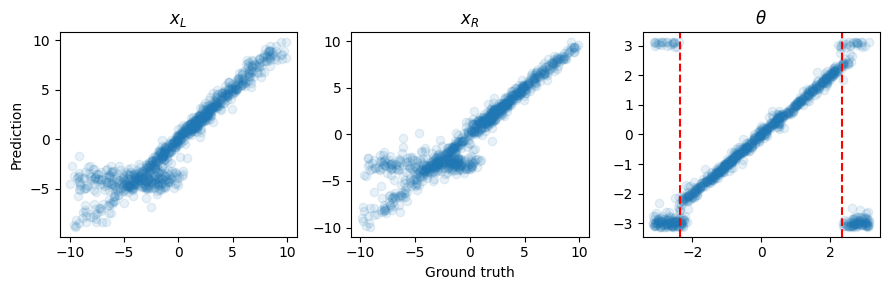

In [16]:
import matplotlib.pyplot as plt

test_indices = datasets["test"].indices
with torch.no_grad():
    coords_lr_pred = model(torch.tensor(images[test_indices])).numpy()

theta_pred = np.angle(coords_lr_pred @ (1, -1j) * np.exp(1j * np.pi / 4))
distances = np.linalg.norm(coords_lr_pred, axis=1)

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i in range(2):
    axs[i].scatter(coords_lr[test_indices, i], coords_lr_pred[:, i], alpha=0.1)

axs[2].scatter(theta[test_indices], theta_pred, alpha=0.1)
axs[2].axvline(x=-2.35, color='r', linestyle='--', label='start')
axs[2].axvline(x=2.35, color='r', linestyle='--', label='end')

axs[0].set_ylabel("Prediction")
axs[1].set_xlabel("Ground truth")

for ax, title in zip(axs, ["$x_L$", "$x_R$", "$\\theta$"]):
    ax.set_title(title)

plt.tight_layout()
plt.savefig("NN_precision")


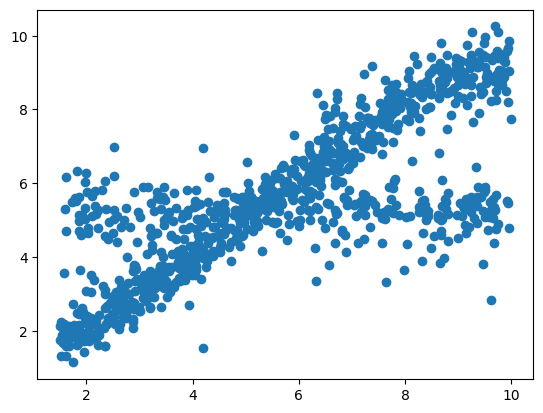

In [9]:
plt.scatter(r[test_indices], distances)
